In [1]:
import warnings
warnings.filterwarnings(action='once')


### Import Libraries

In [2]:
# Data Manipulation & Math 
import pandas as pd     # Handling the dataframes
import numpy as np      # Doing the heavy math lifting

# NLP & Text Cleaning
import re               # Regex: Essential for cleaning up messy text patterns
import nltk             # The main NLP toolbox
from nltk.corpus import stopwords        # Gets rid of filler words like "the", "is", "and"
from nltk.stem import WordNetLemmatizer  # Chops words down to their base (e.g., "running" -> "run")

# Data Visualization
import matplotlib.pyplot as plt  # Standard plotting tool
import seaborn as sns            # Makes the plots look way better/cleaner
from wordcloud import WordCloud  # Creates that cool image showing the most frequent words

# Machine Learning 
from sklearn.model_selection import train_test_split    # Splitting data so we can test properly
from sklearn.feature_extraction.text import TfidfVectorizer # Turns text into numbers (math) so the model understands it
from sklearn.linear_model import LogisticRegression     # The actual model we are training
from sklearn.metrics import (accuracy_score,            # Simple % of how often we were right
                             classification_report,     # The full report card (precision/recall)
                             confusion_matrix,          # Shows exactly where the model got confused
                             roc_curve, auc)            # Advanced charts to check performance

# Saving Model
import joblib           # Saves the trained model so you don't have to retrain it later

C:\Users\bines\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\wordcloud\wordcloud.py:35: ResourceWarning: unclosed file <_io.TextIOWrapper name='C:\\Users\\bines\\AppData\\Local\\Packages\\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\\LocalCache\\local-packages\\Python313\\site-packages\\wordcloud\\stopwords' mode='r' encoding='cp1252'>
  STOPWORDS = set(map(str.strip, open(os.path.join(FILE, 'stopwords')).readlines()))


In [3]:
# SETUP NLTK
print("Setting up NLTK resources...")
try:
    nltk.data.find('tokenizers/punkt')
except LookupError:
    nltk.download('punkt', quiet=True)
    nltk.download('stopwords', quiet=True)
    nltk.download('wordnet', quiet=True)
    nltk.download('omw-1.4', quiet=True)

lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

Setting up NLTK resources...


### Load Data

In [4]:
df = pd.read_csv("./depression_dataset_reddit_cleaned.csv")
df.head()

,clean_text,is_depression
0,we understand that most people who reply immed...,1
1,welcome to r depression s check in post a plac...,1
2,anyone else instead of sleeping more when depr...,1
3,i ve kind of stuffed around a lot in my life d...,1
4,sleep is my greatest and most comforting escap...,1


In [5]:
# Display the first 5 rows to understand structure
display(df.head())

# Check for missing values
print("\nMissing values check:")
print(df.isnull().sum())

,clean_text,is_depression
0,we understand that most people who reply immed...,1
1,welcome to r depression s check in post a plac...,1
2,anyone else instead of sleeping more when depr...,1
3,i ve kind of stuffed around a lot in my life d...,1
4,sleep is my greatest and most comforting escap...,1



Missing values check:
clean_text       0
is_depression    0
dtype: int64


## Text Preprocessing

In [6]:
# Initialize tools
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    """
    1. Converts text to lowercase.
    2. Removes special characters/punctuation.
    3. Tokenizes (splits) into words.
    4. Removes stopwords (common words like 'the', 'is').
    5. Lemmatizes (converts words to their root form, e.g., 'running' -> 'run').
    """
    # Ensure input is string
    text = str(text).lower()
    
    # Remove non-alphabetic characters
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    
    # Split into individual words
    tokens = nltk.word_tokenize(text)
    
    # Keep only meaningful words (no stopwords) and convert to root form
    clean_tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    
    return ' '.join(clean_tokens)

print("Preprocessing text... this may take a few seconds.")
df['processed_text'] = df['clean_text'].astype(str).apply(preprocess_text)

# Create a word count column for Analysis
df['word_count'] = df['processed_text'].apply(lambda x: len(x.split()))

print("Preprocessing Complete!")
display(df[['clean_text', 'processed_text']].head())

Preprocessing text... this may take a few seconds.
Preprocessing Complete!


,clean_text,processed_text
0,we understand that most people who reply immed...,understand people reply immediately op invitat...
1,welcome to r depression s check in post a plac...,welcome r depression check post place take mom...
2,anyone else instead of sleeping more when depr...,anyone else instead sleeping depressed stay ni...
3,i ve kind of stuffed around a lot in my life d...,kind stuffed around lot life delaying inevitab...
4,sleep is my greatest and most comforting escap...,sleep greatest comforting escape whenever wake...


### Exploratory Data Analysis (EDA)

In [7]:
# Analyzing Class Distribution

class_distribution = df['is_depression'].value_counts() # .value_counts() counts the unique occurrences in the 'is_depression' column
class_distribution

is_depression
0    3900
1    3831
Name: count, dtype: int64

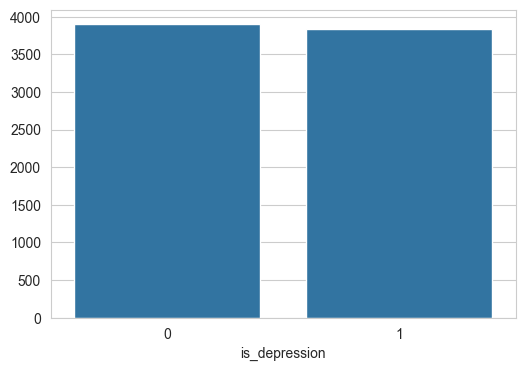

In [8]:
# Visualize the Distribution
sns.set_style("whitegrid")  #   visual style for our plots

plt.figure(figsize=(6, 4)) #  new figure for the plot with a specific size

# Create a bar plot using seaborn.
ax = sns.barplot(
    x=class_distribution.index,  # The labels (0 and 1)
    y=class_distribution.values, # The counts (3900 and 3831)
)

Saved class distribution plot to 'class_distribution_plot.png'


C:\Users\bines\AppData\Local\Temp\ipykernel_28560\2649943785.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(
C:\Users\bines\AppData\Local\Temp\ipykernel_28560\2649943785.py:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['0 (Non-Depressive)', '1 (Depressive)'], fontsize=10)


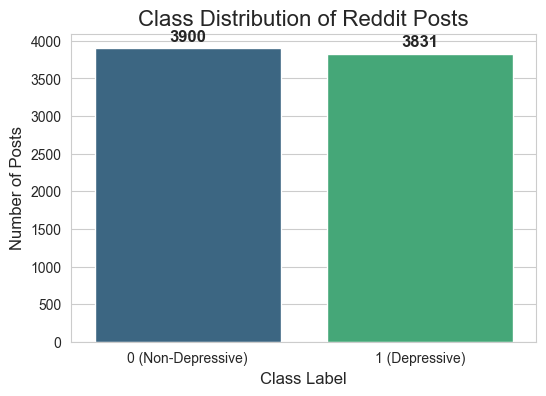

In [9]:
# Set the visual style for our plots.
sns.set_style("whitegrid")
# Create a new figure for the plot with a specific size.
plt.figure(figsize=(6, 4))
# Create a bar plot using seaborn.
ax = sns.barplot(
    x=class_distribution.index,  #  labels (0 and 1)
    y=class_distribution.values, #  counts (3900 and 3831)
    palette="viridis"            # A color scheme
)
# Set the title and axis labels for clarity.
ax.set_title("Class Distribution of Reddit Posts", fontsize=16)
ax.set_xlabel("Class Label", fontsize=12)
ax.set_ylabel("Number of Posts", fontsize=12)
# Change the x-axis ticks from "0" and "1" to more descriptive labels.
ax.set_xticklabels(['0 (Non-Depressive)', '1 (Depressive)'], fontsize=10)
# Add the exact count text on top of each bar.
for i, v in enumerate(class_distribution.values):
    ax.text(i, v + 50, str(v), ha='center', va='bottom', fontsize=12, fontweight='bold')
# Save the plot as an image file in the project folder.
plt.savefig("class_distribution_plot.png")
print("Saved class distribution plot to 'class_distribution_plot.png'")
plt.show()

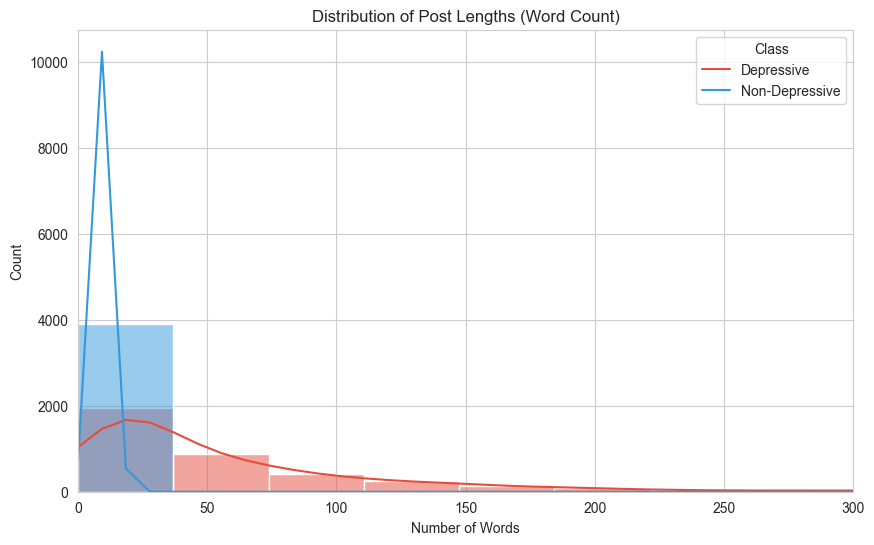

In [11]:
# Text Length Distribution
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='word_count', hue='is_depression', kde=True, bins=50, palette=['#3498db', '#e74c3c'])
plt.title('Distribution of Post Lengths (Word Count)')
plt.xlabel('Number of Words')
plt.xlim(0, 300) # Limit x-axis to zoom in on common lengths
plt.legend(title='Class', labels=['Depressive', 'Non-Depressive'])

plt.savefig("Distribution of Post Lengths (Word Count).png")

plt.show()

## Word Clouds

Visualize the most common words.

C:\Users\bines\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\matplotlib\cbook.py:684: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  x = np.array(x, subok=True, copy=copy)


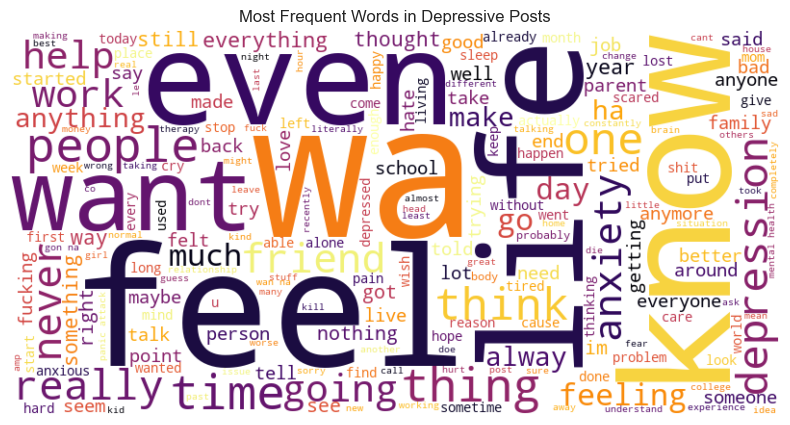

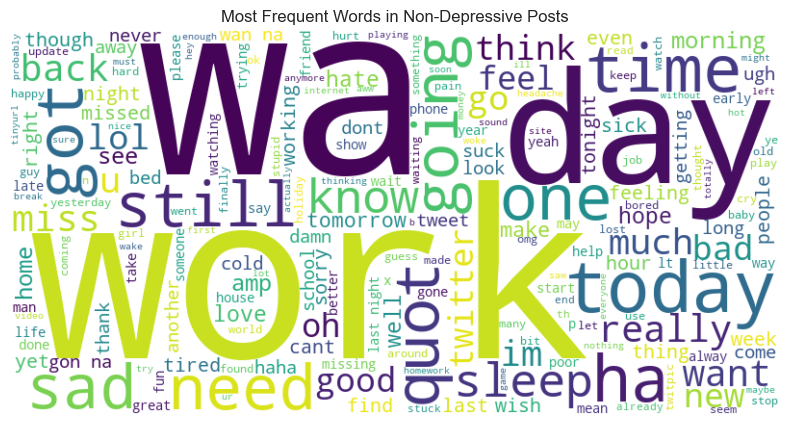

In [12]:
# Separate text by class
depressive_text = " ".join(df[df['is_depression'] == 1]['processed_text'])
non_depressive_text = " ".join(df[df['is_depression'] == 0]['processed_text'])

# Depressive Word Cloud 
wc_dep = WordCloud(width=800, height=400, background_color='white', colormap='inferno').generate(depressive_text)
plt.figure(figsize=(10, 5))
plt.imshow(wc_dep, interpolation='bilinear')
plt.axis('off')
plt.title('Most Frequent Words in Depressive Posts')
plt.savefig('Most Frequent Words in Depressive Posts.png')
plt.show()

# Non-Depressive Word Cloud 
wc_non = WordCloud(width=800, height=400, background_color='white', colormap='viridis').generate(non_depressive_text)
plt.figure(figsize=(10, 5))
plt.imshow(wc_non, interpolation='bilinear')
plt.axis('off')
plt.title('Most Frequent Words in Non-Depressive Posts')
plt.savefig('Most Frequent Words in Non-Depressive Posts.png')
plt.show()

## Feature Extraction & Splitting

Prepare the data for the Machine Learning model.

In [14]:
# 1. TF-IDF Vectorization
# Converts text into numbers. We keep the top 5000 most important words.
print("Vectorizing text...")
vectorizer = TfidfVectorizer(max_features=5000)
X = vectorizer.fit_transform(df['processed_text'])
y = df['is_depression']

# 2. Train-Test Split
# 80% for training, 20% for testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training Data Shape: {X_train.shape}")
print(f"Testing Data Shape: {X_test.shape}")

Vectorizing text...
Training Data Shape: (6184, 5000)
Testing Data Shape: (1547, 5000)


## Model Training (Logistic Regression)

In [15]:
print("Training Logistic Regression Model...")
model = LogisticRegression()
model.fit(X_train, y_train)
print("Training Complete!")

Training Logistic Regression Model...
Training Complete!


## Evaluation & Result Plots

MODEL ACCURACY: 94.83%

Classification Report:

              precision    recall  f1-score   support

           0       0.92      0.98      0.95       783
           1       0.98      0.92      0.95       764

    accuracy                           0.95      1547
   macro avg       0.95      0.95      0.95      1547
weighted avg       0.95      0.95      0.95      1547



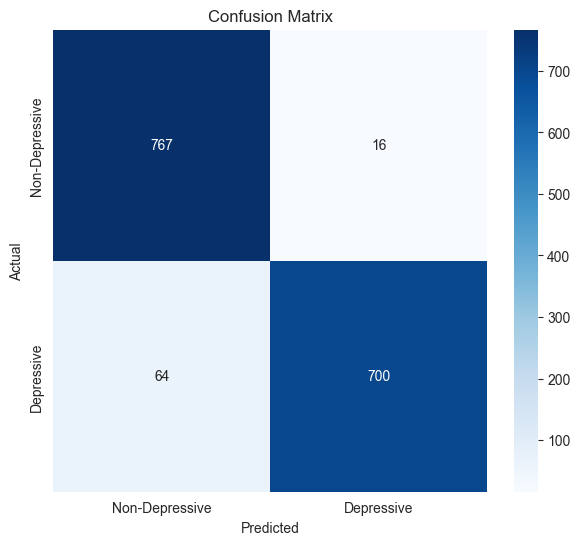

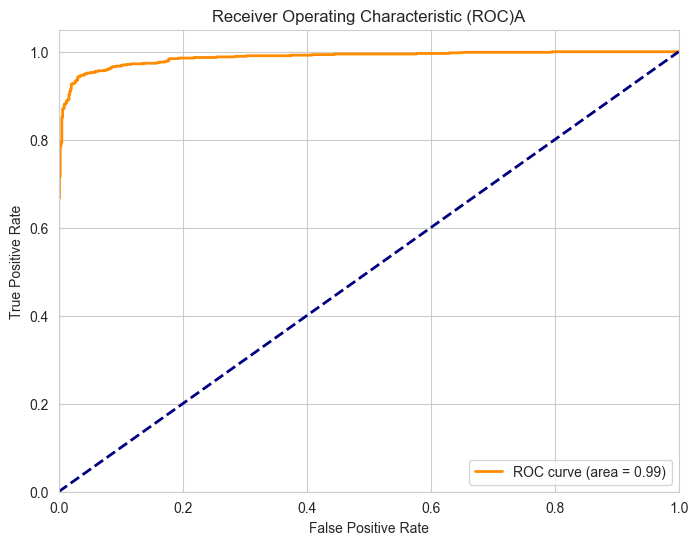

In [16]:
# Make predictions on the test set
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1] # Probabilities for ROC curve

# Calculate basic accuracy
acc = accuracy_score(y_test, y_pred)
print(f"MODEL ACCURACY: {acc*100:.2f}%")
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred))

# --- PLOT 5: Confusion Matrix ---
plt.figure(figsize=(7, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Non-Depressive', 'Depressive'], 
            yticklabels=['Non-Depressive', 'Depressive'])
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.savefig('Confusion Matrix.png')
plt.show()

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)A')
plt.legend(loc="lower right")
plt.savefig('Receiver Operating Characteristic (ROC)A.png')

plt.show()

## Testing model

In [23]:
text = ["I WANT TO KILL MYSELF"]
text_vectorized = vectorizer.transform(text)

In [24]:
prediction = model.predict(text_vectorized)
prediction

array([1])

In [27]:
from sklearn.pipeline import Pipeline
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', LogisticRegression())
])

pipeline.fit(df['processed_text'], df['is_depression'])

joblib.dump(pipeline, "model.joblib")

['model.joblib']

In [21]:
# # Save the model
# joblib_file = "model.joblib"
# joblib.dump(model, joblib_file) 

['model.joblib']

In [ ]:
#